In [2542]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [2543]:
df = pd.read_csv('D:\\Study\\!Geekbrains\\DataScientist\\PythonLibs_For_DS\\Final_Project\\train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('D:\\Study\\!Geekbrains\\DataScientist\\PythonLibs_For_DS\\Final_Project\\test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


15229

In [2544]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [2545]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [2546]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [2547]:
X['Rooms'].value_counts()

# > 6 комнат, = 0 комнат

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [2548]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [2549]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [2550]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [2551]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [2552]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [2553]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


### Заполнение NaN

D:\Soft\Installed_Programms\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


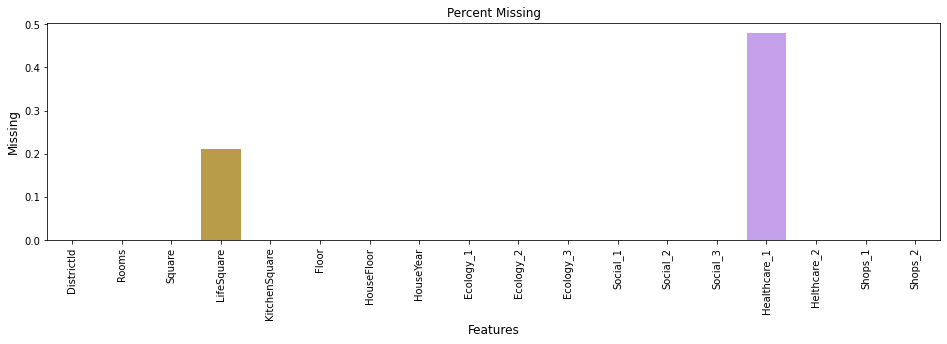

In [2554]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [2555]:
X.DistrictId.nunique()

205

In [2556]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '13': 97,
 '99': 97,
 '47': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '128': 64,
 '12': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '124': 43,
 '129': 43,
 '63': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '15': 36,
 '38': 36,
 '24': 35,
 '5': 34,
 '56': 34,
 '32': 34,
 '103': 33,
 '123': 32,
 '83': 31,
 '19': 31,
 '80': 31,
 '33': 31,
 '130': 29,
 '69': 29,
 '138': 29,
 '64': 28,
 '86': 27,
 '108': 27,
 '70': 27,
 '87': 

# 2. Очистка данных

In [2557]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 1000), 'KitchenSquare_outlier'] = 1
        
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
#       # LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] < 0) | (X['LifeSquare'] > 3000), 'LifeSquare_outlier'] = 1
        
        X.loc[X['LifeSquare'] < 5, 'LifeSquare'] = 5
        X.loc[X['LifeSquare'] > 3000, 'LifeSquare'] = X.loc[X['LifeSquare'] > 3000, 'LifeSquare'] / 10  # можно median
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X
        

In [2558]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [2559]:
X.loc[X['LifeSquare'] < 5, 'LifeSquare'] = 5
X_final.loc[X_final['LifeSquare'] < 5, 'LifeSquare'] = 5

# 3. Feature engineering

In [2560]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district_rooms = None
        self.med_price_by_floor_year = None
        self.med_price_by_house_floor_year = None
        self.med_price_by_rooms_square = None
        self.med_price_by_rooms_life_square = None
        self.med_price_by_house_year = None
        self.med_price_by_floor = None
        self.med_price_by_house_floor = None
        self.med_price_by_rooms = None
        self.med_price_by_square = None
        self.med_price_by_life_square = None
        self.med_price_by_kitchen_square = None
        self.med_price_by_shops1 = None
        self.med_price_by_ecology_1 = None
        self.med_price_by_floor_cat = None
        self.med_price_by_house_floor_cat = None
        self.med_price_by_district_and_lsquare = None
        self.med_price_by_district_and_square = None
        self.med_price_by_square_ecology_1 = None
        self.med_price_by_square_and_lsquare = None
        self.med_price_by_district_and_year = None
        self.med_price_by_social1 = None
        self.med_price_by_lifeSquareToSquare = None
        self.med_price_by_kitchenSquareToSquare = None
        self.med_price_by_district = None
        
        self.med_price_by_district_shops_1 = None
        self.med_price_by_district_ecology_1 = None
        self.med_price_by_district_social_1 = None
        self.med_price_by_square_shop_1 = None
        self.med_price_by_square_social_1 = None
        self.med_price_by_lifesquare_and_shops_1 = None
#         self.med_price_by_lifesquare_and_shops_2 = None
        self.med_price_by_lifesquare_and_ecology_1 = None
        self.med_price_by_lifesquare_and_social_1 = None
        self.med_price_by_district_square_shop_1 = None
        self.med_price_by_district_square_ecology_1 = None
        self.med_price_by_district_square_social_1 = None
        self.med_price_by_district_lifeSquare_shop_1 = None
        self.med_price_by_district_lifeSquare_ecology_1 = None
        self.med_price_by_district_lifeSquare_social_1 = None
        
        self.med_price_by_district_kitchenSquare = None
        self.med_price_by_district_kitchenSquare_shop_1 = None
        self.med_price_by_district_kitchenSquare_ecology_1 = None
        self.med_price_by_district_kitchenSquare_social_1 = None
        
        self.med_price_by_district_social_3 = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            
            self.med_price_by_district_rooms = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrictRooms',
                                                           'DistrictId_popular': 'DistrictId'})
            
            self.med_price_by_house_year = df.groupby('HouseYear', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouseYear'})
            
            self.med_price_by_floor = df.groupby('Floor', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloor'})
            
            self.med_price_by_house_floor = df.groupby('HouseFloor', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouseFloor'})
            
            self.med_price_by_rooms = df.groupby('Rooms', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByRooms'})
            
            self.med_price_by_shops1 = df.groupby('Shops_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops1'})  
            
            self.med_price_by_social1 = df.groupby('Social_1', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial1'}) 
            
            
            self.med_price_by_district_social_3 = df.groupby(['DistrictId', 'Social_3'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistSocial_3'})
            
            
            self.med_price_by_district = df.groupby('DistrictId', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict'})
            
            
            self.med_price_by_district_shops_1 = df.groupby(['DistrictId', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_Shops_1'})
            self.med_price_by_district_social_1 = df.groupby(['DistrictId', 'Social_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_Social_1'})
            
            
            
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
            self.med_price_by_floor_cat = df.groupby(['floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorCat'})
            
            self.med_price_by_district_and_year = df.groupby(['DistrictId', 'year_cat'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrictAndYear'})
            
        ## HouseFloor, year
        if y is not None:
            df['Price'] = y.values
            df = self.house_floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_house_floor_year = df.groupby(['year_cat', 'house_floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouseFloorYear'})
            self.med_price_by_house_floor_cat = df.groupby('house_floor_cat').agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouseFloorCat'})
            
            
         ## rooms, square
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)
            self.med_price_by_rooms_square = df.groupby(['Rooms', 'square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByRooms_Square'})
            self.med_price_by_square = df.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})                  
            self.med_price_by_district_and_square = df.groupby(['DistrictId', 'square_cat'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrictAndSquare'})
            
            
            self.med_price_by_square_shop_1 = df.groupby(['square_cat', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare_Shops_1'})
            self.med_price_by_square_social_1 = df.groupby(['square_cat', 'Social_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare_Social_1'})
            
            
        ## rooms, LifeSquare
        if y is not None:
            df['Price'] = y.values
            df = self.life_square_to_cat(df)
            self.med_price_by_rooms_life_square = df.groupby(['Rooms', 'life_square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByRooms_LifeSquare'})
            self.med_price_by_life_square = df.groupby('life_square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByLifeSquare'})
            self.med_price_by_district_and_lsquare = df.groupby(['DistrictId', 'life_square_cat'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrictAndLifeSquare'})
            self.med_price_by_square_and_lsquare = df.groupby(['square_cat', 'life_square_cat'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceBySquareAndLifeSquareCat'})
            
            
            self.med_price_by_lifesquare_and_shops_1 = df.groupby(['life_square_cat', 'Shops_1'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByLifeSquareCat_Shops_1'})
#             self.med_price_by_lifesquare_and_shops_2 = df.groupby(['life_square_cat', 'Shops_2'], as_index=False).\
#                                             agg({'Price':'median'}).rename(columns={'Price':'MedPriceByLifeSquareCat_Shops_2'})
            self.med_price_by_lifesquare_and_ecology_1 = df.groupby(['life_square_cat', 'Ecology_1'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByLifeSquareCat_Ecology_1'})
            self.med_price_by_lifesquare_and_social_1 = df.groupby(['life_square_cat', 'Social_1'], as_index=False).\
                                            agg({'Price':'median'}).rename(columns={'Price':'MedPriceByLifeSquareCat_Social_1'})
        
        
        ## KitchenSquare
        if y is not None:    
            df['Price'] = y.values
            df = self.kitchen_square_to_cat(df)
            df = self.ecology_1_to_cat(df)
            self.med_price_by_kitchen_square = df.groupby('kitchen_square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByKitchenSquare'})
            
            self.med_price_by_district_kitchenSquare = df.groupby(['DistrictId', 'kitchen_square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_KitchSquareCat'})
            
            self.med_price_by_district_kitchenSquare_shop_1 = df.groupby(['DistrictId', 'kitchen_square_cat', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_KitchSquareCat_Shops_1'})
            self.med_price_by_district_kitchenSquare_ecology_1 = df.groupby(['DistrictId', 'kitchen_square_cat', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_KitchSquareCat_Ecology_1_Cat'})
            self.med_price_by_district_kitchenSquare_social_1 = df.groupby(['DistrictId', 'kitchen_square_cat', 'Social_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_KitchSquareCat_Social_1'})
            
            
        ## Ecology_1, square
        if y is not None:    
            df['Price'] = y.values
            df = self.ecology_1_to_cat(df)
            df = self.square_to_cat(df)
            self.med_price_by_ecology_1 = df.groupby('ecology_1_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcology_1'})
            
            self.med_price_by_square_ecology_1 = df.groupby(['square_cat', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareAndEcology_1'})
            
            self.med_price_by_district_ecology_1 = df.groupby(['DistrictId', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_Ecology_1_Cat'})
            
            self.med_price_by_district_square_shop_1 = df.groupby(['DistrictId', 'square_cat', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_SquareCat_Shops_1'})
            self.med_price_by_district_square_ecology_1 = df.groupby(['DistrictId', 'square_cat', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_SquareCat_Ecology_1_Cat'})
            self.med_price_by_district_square_social_1 = df.groupby(['DistrictId', 'square_cat', 'Social_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_SquareCat_Social_1'})
            
        
            
        
        ## lifeSquareToSquare
        if y is not None:    
            df['Price'] = y.values
            df = self.ecology_1_to_cat(df)
            df = self.lifesquare_to_square(df)
            self.med_price_by_lifeSquareToSquare = df.groupby('LifeSquareToSquare', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByLifeSquareToSquare'}) 
            
            self.med_price_by_district_lifeSquare_shop_1 = df.groupby(['DistrictId', 'life_square_cat', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_LifeSquareCat_Shops_1'})
            self.med_price_by_district_lifeSquare_ecology_1 = df.groupby(['DistrictId', 'life_square_cat', 'ecology_1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_LifeSquareCat_Ecology_1_Cat'})
            self.med_price_by_district_lifeSquare_social_1 = df.groupby(['DistrictId', 'life_square_cat', 'Social_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict_LifeSquareCat_Social_1'})
            
            
        ## KitchenSquareToSquare
        if y is not None:    
            df['Price'] = y.values
            df = self.kitchensquare_to_square(df)
            self.med_price_by_kitchenSquareToSquare = df.groupby('KitchenSquareToSquare', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByKitchenSquareToSquare'}) 
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.house_floor_to_cat(X)  # + столбец house_floor_cat
        X = self.square_to_cat(X) # + столбец square_cat
        X = self.life_square_to_cat(X) # + столбец life_square_cat
        X = self.kitchen_square_to_cat(X) # + столбец kitchen_square_cat
        X = self.ecology_1_to_cat(X) # + столбец ecology_1_cat
        X = self.lifesquare_to_square(X) # + столбец LifeSquareToSquare
        X = self.kitchensquare_to_square(X) # + столбец KitchenSquareToSquare
        X = self.floor_to_houseFloor(X) # + столбец FloorToHouseFloor
        
        # Target encoding
        if self.med_price_by_district_rooms is not None:
            X = X.merge(self.med_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_house_floor_year is not None:
            X = X.merge(self.med_price_by_house_floor_year, on=['year_cat', 'house_floor_cat'], how='left')
        if self.med_price_by_rooms_square is not None:
            X = X.merge(self.med_price_by_rooms_square, on=['Rooms', 'square_cat'], how='left')
        if self.med_price_by_rooms_life_square is not None:
            X = X.merge(self.med_price_by_rooms_life_square, on=['Rooms', 'life_square_cat'], how='left')
        if self.med_price_by_house_year is not None:
            X = X.merge(self.med_price_by_house_year, on=['HouseYear'], how='left')
        if self.med_price_by_floor is not None:
            X = X.merge(self.med_price_by_floor, on=['Floor'], how='left')
        if self.med_price_by_house_floor is not None:
            X = X.merge(self.med_price_by_house_floor, on=['HouseFloor'], how='left') 
        if self.med_price_by_rooms is not None:
            X = X.merge(self.med_price_by_rooms, on=['Rooms'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
        if self.med_price_by_life_square is not None:
            X = X.merge(self.med_price_by_life_square, on=['life_square_cat'], how='left')
        if self.med_price_by_kitchen_square is not None:
            X = X.merge(self.med_price_by_kitchen_square, on=['kitchen_square_cat'], how='left')
        if self.med_price_by_shops1 is not None:
            X = X.merge(self.med_price_by_shops1, on=['Shops_1'], how='left')
        if self.med_price_by_ecology_1 is not None:
            X = X.merge(self.med_price_by_ecology_1, on=['ecology_1_cat'], how='left')
        if self.med_price_by_floor_cat is not None:
            X = X.merge(self.med_price_by_floor_cat, on=['floor_cat'], how='left')
        if self.med_price_by_house_floor_cat is not None:
            X = X.merge(self.med_price_by_house_floor_cat, on=['house_floor_cat'], how='left')
        if self.med_price_by_district_and_lsquare is not None:
            X = X.merge(self.med_price_by_district_and_lsquare, on=['DistrictId', 'life_square_cat'], how='left')
        if self.med_price_by_district_and_square is not None:
            X = X.merge(self.med_price_by_district_and_square, on=['DistrictId', 'square_cat'], how='left')
        if self.med_price_by_square_ecology_1 is not None:
            X = X.merge(self.med_price_by_square_ecology_1, on=['square_cat', 'ecology_1_cat'], how='left')
        if self.med_price_by_square_and_lsquare is not None:
            X = X.merge(self.med_price_by_square_and_lsquare, on=['square_cat', 'life_square_cat'], how='left')
        if self.med_price_by_district_and_year is not None:
            X = X.merge(self.med_price_by_district_and_year, on=['DistrictId', 'year_cat'], how='left')
        if self.med_price_by_social1 is not None:
            X = X.merge(self.med_price_by_social1, on='Social_1', how='left')
        if self.med_price_by_lifeSquareToSquare is not None:
            X = X.merge(self.med_price_by_lifeSquareToSquare, on='LifeSquareToSquare', how='left')
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on='DistrictId', how='left')
            
        if self.med_price_by_district_shops_1 is not None:
            X = X.merge(self.med_price_by_district_shops_1, on=['DistrictId', 'Shops_1'], how='left')
        if self.med_price_by_district_ecology_1 is not None:
            X = X.merge(self.med_price_by_district_ecology_1, on=['DistrictId', 'ecology_1_cat'], how='left')
        if self.med_price_by_district_social_1 is not None:
            X = X.merge(self.med_price_by_district_social_1, on=['DistrictId', 'Social_1'], how='left')
        if self.med_price_by_square_shop_1 is not None:
            X = X.merge(self.med_price_by_square_shop_1, on=['square_cat', 'Shops_1'], how='left')
        if self.med_price_by_square_social_1 is not None:
            X = X.merge(self.med_price_by_square_social_1, on=['square_cat', 'Social_1'], how='left')
            
        if self.med_price_by_lifesquare_and_shops_1 is not None:
            X = X.merge(self.med_price_by_lifesquare_and_shops_1, on=['life_square_cat', 'Shops_1'], how='left')
#         if self.med_price_by_lifesquare_and_shops_2 is not None:
#             X = X.merge(self.med_price_by_lifesquare_and_shops_2, on=['life_square_cat', 'Shops_2'], how='left')
        if self.med_price_by_lifesquare_and_ecology_1 is not None:
            X = X.merge(self.med_price_by_lifesquare_and_ecology_1, on=['life_square_cat', 'Ecology_1'], how='left')
        if self.med_price_by_lifesquare_and_social_1 is not None:
            X = X.merge(self.med_price_by_lifesquare_and_social_1, on=['life_square_cat', 'Social_1'], how='left')
        if self.med_price_by_district_square_shop_1 is not None:
            X = X.merge(self.med_price_by_district_square_shop_1, on=['DistrictId', 'square_cat', 'Shops_1'], how='left')
        if self.med_price_by_district_square_ecology_1 is not None:
            X = X.merge(self.med_price_by_district_square_ecology_1, on=['DistrictId', 'square_cat', 'ecology_1_cat'], how='left')
        if self.med_price_by_district_square_social_1 is not None:
            X = X.merge(self.med_price_by_district_square_social_1, on=['DistrictId', 'square_cat', 'Social_1'], how='left')
        if self.med_price_by_district_lifeSquare_shop_1 is not None:
            X = X.merge(self.med_price_by_district_lifeSquare_shop_1, on=['DistrictId', 'life_square_cat', 'Shops_1'], how='left')
        if self.med_price_by_district_lifeSquare_ecology_1 is not None:
            X = X.merge(self.med_price_by_district_lifeSquare_ecology_1, on=['DistrictId', 'life_square_cat', 'ecology_1_cat'], how='left')
        if self.med_price_by_district_lifeSquare_social_1 is not None:
            X = X.merge(self.med_price_by_district_lifeSquare_social_1, on=['DistrictId', 'life_square_cat', 'Social_1'], how='left')
        
        if self.med_price_by_district_kitchenSquare is not None:
            X = X.merge(self.med_price_by_district_kitchenSquare, on=['DistrictId', 'kitchen_square_cat'], how='left')
        if self.med_price_by_district_kitchenSquare_shop_1 is not None:
            X = X.merge(self.med_price_by_district_kitchenSquare_shop_1, on=['DistrictId', 'kitchen_square_cat', 'Shops_1'], how='left')
        if self.med_price_by_district_kitchenSquare_ecology_1 is not None:
            X = X.merge(self.med_price_by_district_kitchenSquare_ecology_1, on=['DistrictId', 'kitchen_square_cat', 'ecology_1_cat'], how='left')
        if self.med_price_by_district_kitchenSquare_social_1 is not None:
            X = X.merge(self.med_price_by_district_kitchenSquare_social_1, on=['DistrictId', 'kitchen_square_cat', 'Social_1'], how='left')
            
        if self.med_price_by_district_social_3 is not None:
            X = X.merge(self.med_price_by_district_social_3, on=['DistrictId', 'Social_3'], how='left')

        


#         X['MeanRoomsInDistrict'] = X['Square'] / (X.groupby('DistrictId').agg({'Square':'sum'}))
             
        return X
    
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
        
        return X
    
    @staticmethod
    def house_floor_to_cat(X):
        
        X['house_floor_cat'] = np.nan
        
        X.loc[X['HouseFloor'] < 10, 'house_floor_cat'] = 1  
        X.loc[(X['HouseFloor'] >= 10) & (X['HouseFloor'] <= 40), 'house_floor_cat'] = 2
        X.loc[(X['HouseFloor'] > 40) & (X['HouseFloor'] <= 70), 'house_floor_cat'] = 3
        X.loc[(X['HouseFloor'] > 70) & (X['HouseFloor'] <= 100), 'house_floor_cat'] = 4
        X.loc[X['HouseFloor'] > 100, 'house_floor_cat'] = 5
            
        return X
        
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = np.nan
        
        X.loc[X['Square'] < 10, 'square_cat'] = 1
        X.loc[(X['Square'] >= 10) & (X['Square'] <= 75.55), 'square_cat'] = 2
        X.loc[(X['Square'] > 75.55) & (X['Square'] <= 141.11), 'square_cat'] = 3
        X.loc[(X['Square'] > 141.11) & (X['Square'] <= 206.66), 'square_cat'] = 4
        X.loc[(X['Square'] > 206.66) & (X['Square'] <= 272.22), 'square_cat'] = 5
        X.loc[(X['Square'] > 272.22) & (X['Square'] <= 337.77), 'square_cat'] = 6
        X.loc[(X['Square'] > 337.77) & (X['Square'] <= 403.33), 'square_cat'] = 7
        X.loc[(X['Square'] > 403.33) & (X['Square'] <= 468.88), 'square_cat'] = 8
        X.loc[(X['Square'] > 468.88) & (X['Square'] <= 534.44), 'square_cat'] = 9
        X.loc[(X['Square'] > 534.44) & (X['Square'] <= 600), 'square_cat'] = 10
        X.loc[(X['Square'] > 600), 'square_cat'] = 11
        
        return X
        
    @staticmethod
    def life_square_to_cat(X):
        
        X['life_square_cat'] = np.nan
        
        X.loc[X['LifeSquare'] < 10, 'life_square_cat'] = 1
        X.loc[(X['LifeSquare'] >= 10) & (X['LifeSquare'] <= 44.105), 'life_square_cat'] = 2
        X.loc[(X['LifeSquare'] > 44.105) & (X['LifeSquare'] <= 83.211), 'life_square_cat'] = 3
        X.loc[(X['LifeSquare'] > 83.211) & (X['LifeSquare'] <= 122.316), 'life_square_cat'] = 4
        X.loc[(X['LifeSquare'] > 122.316) & (X['LifeSquare'] <= 161.421), 'life_square_cat'] = 5
        X.loc[(X['LifeSquare'] > 161.421) & (X['LifeSquare'] <= 200.526), 'life_square_cat'] = 6
        X.loc[(X['LifeSquare'] > 200.526) & (X['LifeSquare'] <= 239.632), 'life_square_cat'] = 7
        X.loc[(X['LifeSquare'] > 239.632) & (X['LifeSquare'] <= 278.737), 'life_square_cat'] = 8
        X.loc[(X['LifeSquare'] > 278.737) & (X['LifeSquare'] <= 317.842), 'life_square_cat'] = 9
        X.loc[(X['LifeSquare'] > 317.842) & (X['LifeSquare'] <= 356.947), 'life_square_cat'] = 10
        X.loc[(X['LifeSquare'] > 356.947) & (X['LifeSquare'] <= 396.053), 'life_square_cat'] = 11
        X.loc[(X['LifeSquare'] > 396.053) & (X['LifeSquare'] <= 435.158), 'life_square_cat'] = 12
        X.loc[(X['LifeSquare'] > 435.158) & (X['LifeSquare'] <= 474.263), 'life_square_cat'] = 13
        X.loc[(X['LifeSquare'] > 474.263) & (X['LifeSquare'] <= 513.368), 'life_square_cat'] = 14
        X.loc[(X['LifeSquare'] > 513.368) & (X['LifeSquare'] <= 552.474), 'life_square_cat'] = 15
        X.loc[(X['LifeSquare'] > 552.474) & (X['LifeSquare'] <= 591.580), 'life_square_cat'] = 16
        X.loc[(X['LifeSquare'] > 591.580) & (X['LifeSquare'] <= 630.684), 'life_square_cat'] = 17
        X.loc[(X['LifeSquare'] > 630.684) & (X['LifeSquare'] <= 669.789), 'life_square_cat'] = 18
        X.loc[(X['LifeSquare'] > 669.789) & (X['LifeSquare'] <= 708.894), 'life_square_cat'] = 19
        X.loc[(X['LifeSquare'] > 708.894), 'life_square_cat'] = 20
    
        return X
        
    @staticmethod
    def kitchen_square_to_cat(X):
        
        X['kitchen_square_cat'] = np.nan
        
        X.loc[X['KitchenSquare'] < 5, 'kitchen_square_cat'] = 1  
        X.loc[(X['KitchenSquare'] >= 5) & (X['KitchenSquare'] <= 25), 'kitchen_square_cat'] = 2
        X.loc[(X['KitchenSquare'] > 25) & (X['KitchenSquare'] <= 47), 'kitchen_square_cat'] = 3
        X.loc[(X['KitchenSquare'] > 47) & (X['KitchenSquare'] <= 69), 'kitchen_square_cat'] = 4
        X.loc[(X['KitchenSquare'] > 69) & (X['KitchenSquare'] <= 91), 'kitchen_square_cat'] = 5
        X.loc[(X['KitchenSquare'] > 91) & (X['KitchenSquare'] <= 113), 'kitchen_square_cat'] = 6
        X.loc[(X['KitchenSquare'] > 113) & (X['KitchenSquare'] <= 135), 'kitchen_square_cat'] =7
        X.loc[(X['KitchenSquare'] > 135) & (X['KitchenSquare'] <= 157), 'kitchen_square_cat'] = 8
        X.loc[(X['KitchenSquare'] > 157) & (X['KitchenSquare'] <= 179), 'kitchen_square_cat'] = 9
        X.loc[X['KitchenSquare'] > 179, 'kitchen_square_cat'] = 10
            
        return X
    
    
    @staticmethod
    def ecology_1_to_cat(X):
        
        X['ecology_1_cat'] = np.nan
        
        X.loc[X['Ecology_1'] < 0.0275, 'ecology_1_cat'] = 1  
        X.loc[(X['Ecology_1'] >= 0.0275) & (X['Ecology_1'] <= 0.0545), 'ecology_1_cat'] = 2
        X.loc[(X['Ecology_1'] > 0.055) & (X['Ecology_1'] <= 0.082), 'ecology_1_cat'] = 3
        X.loc[(X['Ecology_1'] > 0.082) & (X['Ecology_1'] <= 0.137), 'ecology_1_cat'] = 4
        X.loc[(X['Ecology_1'] > 0.137) & (X['Ecology_1'] <= 0.165), 'ecology_1_cat'] = 5
        X.loc[(X['Ecology_1'] > 0.165) & (X['Ecology_1'] <= 0.192), 'ecology_1_cat'] = 6
        X.loc[(X['Ecology_1'] > 0.192) & (X['Ecology_1'] <= 0.219), 'ecology_1_cat'] = 7
        X.loc[(X['Ecology_1'] > 0.219) & (X['Ecology_1'] <= 0.247), 'ecology_1_cat'] = 8
        X.loc[(X['Ecology_1'] > 0.247) & (X['Ecology_1'] <= 0.275), 'ecology_1_cat'] = 9
        X.loc[(X['Ecology_1'] > 0.275) & (X['Ecology_1'] <= 0.302), 'ecology_1_cat'] = 10
        X.loc[(X['Ecology_1'] > 0.302) & (X['Ecology_1'] <= 0.330), 'ecology_1_cat'] = 11
        X.loc[(X['Ecology_1'] > 0.330) & (X['Ecology_1'] <= 0.357), 'ecology_1_cat'] = 12
        X.loc[(X['Ecology_1'] > 0.357) & (X['Ecology_1'] <= 0.385), 'ecology_1_cat'] = 13
        X.loc[(X['Ecology_1'] > 0.385) & (X['Ecology_1'] <= 0.412), 'ecology_1_cat'] = 14
        X.loc[(X['Ecology_1'] > 0.412) & (X['Ecology_1'] <= 0.439), 'ecology_1_cat'] = 15
        X.loc[(X['Ecology_1'] > 0.439) & (X['Ecology_1'] <= 0.467), 'ecology_1_cat'] = 16
        X.loc[(X['Ecology_1'] > 0.467) & (X['Ecology_1'] <= 0.494), 'ecology_1_cat'] = 17
        X.loc[(X['Ecology_1'] > 0.494) & (X['Ecology_1'] <= 0.521), 'ecology_1_cat'] = 18
        X.loc[X['Ecology_1'] > 0.521, 'ecology_1_cat'] = 19
            
        return X
    
    @staticmethod
    def lifesquare_to_square(X):
        X['LifeSquareToSquare'] = X['LifeSquare'] / X['Square'] * 100
        return X
    
    @staticmethod
    def kitchensquare_to_square(X):
        X['KitchenSquareToSquare'] = X['KitchenSquare'] / X['Square'] * 100
        return X
    
    @staticmethod
    def floor_to_houseFloor(X):
        X['FloorToHouseFloor'] = X['Floor'] / X['HouseFloor'] * 100
        return X
    
            

In [2561]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [2562]:
# X["Social_1"].value_counts()

In [2563]:
np.linspace(3.0, 201, 10)

array([  3.,  25.,  47.,  69.,  91., 113., 135., 157., 179., 201.])

In [2564]:
X.head(2).T

,0,1
DistrictId,35,41
Rooms,2,3
Square,47.9816,65.6836
LifeSquare,29.4428,40.0495
KitchenSquare,6,8
...,...,...
MedPriceByDistrict_KitchSquareCat,NaN,210819
MedPriceByDistrict_KitchSquareCat_Shops_1,NaN,172139
MedPriceByDistrict_KitchSquareCat_Ecology_1_Cat,NaN,172139
MedPriceByDistrict_KitchSquareCat_Social_1,NaN,172139


In [2565]:
X['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
568       3
1423      3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [2566]:
remain_features = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                   'HouseFloor', 'HouseYear',
                  'DistrictId_count', 'MedPriceByDistrictRooms',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear', 'MedPriceByRooms_LifeSquare', 'MedPriceByHouseFloorYear',
                  'MedPriceByHouseYear', 'MedPriceByFloor', 'MedPriceByHouseFloor','MedPriceByShops1', 'MedPriceByEcology_1', 
                   'MedPriceByDistrictAndLifeSquare', 'MedPriceByDistrictAndSquare', 'MedPriceBySquareAndEcology_1', 
                    'MedPriceByDistrictAndYear', 'MedPriceBySocial1', 'LifeSquareToSquare',
                  'KitchenSquareToSquare', 'MedPriceByDistrict_Shops_1', 'MedPriceByDistrict_Social_1',
                  'MedPriceByDistrict_Ecology_1_Cat', 'MedPriceBySquare_Shops_1', 'MedPriceBySquare_Social_1',
                  'FloorToHouseFloor', 'MedPriceByLifeSquareCat_Shops_1', 
                  'MedPriceByLifeSquareCat_Ecology_1', 'MedPriceByLifeSquareCat_Social_1', 'MedPriceByDistrict_SquareCat_Shops_1',
                  'MedPriceByDistrict_SquareCat_Ecology_1_Cat', 'MedPriceByDistrict_SquareCat_Social_1',
                  'MedPriceByDistrict_LifeSquareCat_Shops_1', 'MedPriceByDistrict_LifeSquareCat_Ecology_1_Cat',
                  'MedPriceByDistrict_LifeSquareCat_Social_1', 'MedPriceByDistrict_KitchSquareCat_Shops_1',
                  'MedPriceByDistrict_KitchSquareCat_Ecology_1_Cat', 'MedPriceByDistrict_KitchSquareCat_Social_1',
                  'MedPriceByDistrict_KitchSquareCat',
                  'Ecology_2', 'Ecology_3', 'Social_2', 'Social_3']

#  'Shops_2','MedPriceBySquareAndLifeSquareCat','HouseFloor_outlier','Rooms', 'MedPriceByRooms_Square', 
# , 'MedPriceByDistSocial_3'

X = X[remain_features]
X_final = X_final[remain_features]

In [2567]:
# X.fillna(X.mean(), inplace=True)
# X_final.fillna(X_final.mean(), inplace=True)

# 4. Модель

In [2568]:
model = LGBMRegressor(max_depth=10, 
                      num_leaves=25, 
                      min_data_in_leaf=45,
                      min_samples_leaf=10,
                      n_estimators=300,
                      random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
R2: 0.754 +- 0.013


In [2569]:
# Обучаю модель на всем трейне
model.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


LGBMRegressor(max_depth=10, min_data_in_leaf=45, min_samples_leaf=10,
              n_estimators=300, num_leaves=25, random_state=42)

In [2570]:
# rfr = RandomForestRegressor(max_depth=10, 
#                       min_samples_leaf=10,
#                       n_estimators=300,
#                       random_state=42)

# X.fillna(X.mean(), inplace=True)
# # rfr.fit(X, y.values.ravel())
# cv_score = cross_val_score(rfr, X, y.values.ravel(), 
#                            scoring='r2', 
#                            cv=KFold(n_splits=5, shuffle=True, random_state=42))
# # cv_score
# mean = cv_score.mean()
# std = cv_score.std()

# print('R2: {:.3f} +- {:.3f}'.format(mean, std))

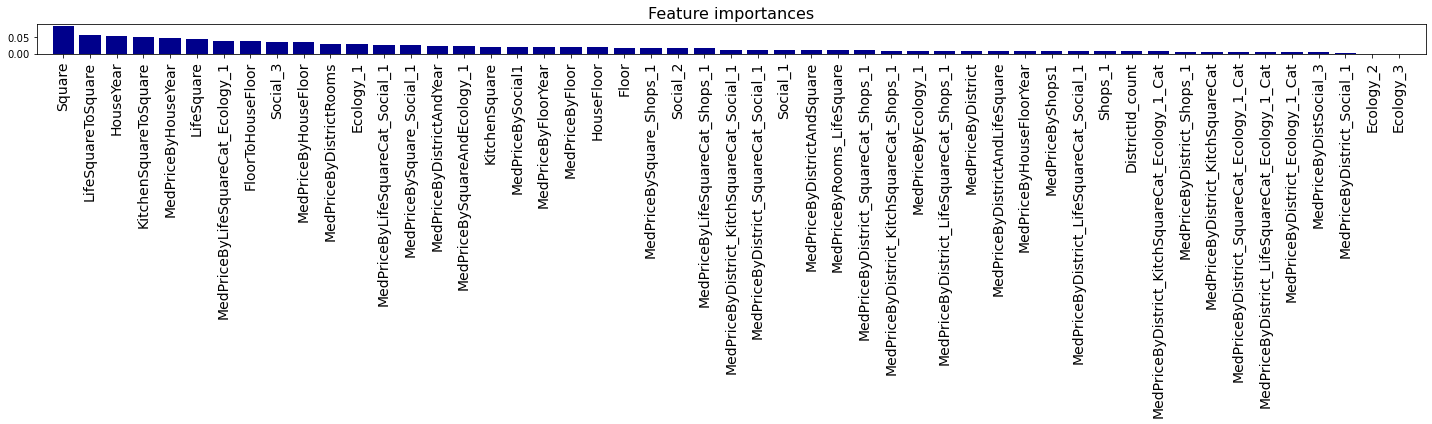

In [2571]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [2572]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('D:\\Study\\!Geekbrains\\DataScientist\\PythonLibs_For_DS\\Final_Project\\predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,153936.921500
1,15856,237844.434687
2,5480,269130.102143
3,15664,341402.844448
4,14275,138031.264575


In [2573]:
preds_final.shape

(5000, 2)